In [55]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from datetime import datetime

In [56]:
BASE_DIR = os.getcwd()
RAW_DIR = os.path.join(BASE_DIR, "data", "raw")
CLEAN_DIR = os.path.join(BASE_DIR, "data", "clean")

os.makedirs(RAW_DIR, exist_ok=True)
os.makedirs(CLEAN_DIR, exist_ok=True)

In [57]:
def standardize_ohlcv(df):
    df = df.reset_index()

    if 'Datetime' in df.columns:
        time_col = 'Datetime'
    elif 'Date' in df.columns:
        time_col = 'Date'
    else:
        raise ValueError("No datetime column found")

    df = df.rename(columns={
        time_col: 'timestamp',
        'Open': 'open',
        'High': 'high',
        'Low': 'low',
        'Close': 'close',
        'Volume': 'volume'
    })

    return df[['timestamp','open','high','low','close','volume']]


def flatten_columns(df):
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [c[0] for c in df.columns]
    return df

In [58]:
import yfinance as yf

spot = yf.download("^NSEI", interval="5m", period="60d", progress=False)
spot = standardize_ohlcv(spot)
spot.to_csv(f"{RAW_DIR}/nifty_spot_5min.csv", index=False)

spot.head()

Price,timestamp,open,high,low,close,volume
Ticker,,^NSEI,^NSEI,^NSEI,^NSEI,^NSEI
0,2025-10-24 03:45:00+00:00,25939.300781,25939.300781,25846.050781,25850.800781,0
1,2025-10-24 03:50:00+00:00,25851.150391,25892.400391,25840.400391,25886.000000,0
2,2025-10-24 03:55:00+00:00,25886.300781,25893.300781,25859.500000,25886.400391,0
3,2025-10-24 04:00:00+00:00,25885.849609,25887.599609,25864.500000,25875.400391,0
4,2025-10-24 04:05:00+00:00,25876.150391,25914.699219,25862.550781,25914.300781,0


In [59]:
fut = spot.copy()
basis = 0.0002  # ~0.02%

fut['open_fut'] = fut['open'] * (1 + basis)
fut['high_fut'] = fut['high'] * (1 + basis)
fut['low_fut']  = fut['low']  * (1 + basis)
fut['close_fut'] = fut['close'] * (1 + basis)
fut['volume_fut'] = fut['volume']
fut['open_interest'] = np.nan

fut = fut[['timestamp','open_fut','high_fut','low_fut',
           'close_fut','volume_fut','open_interest']]

fut.to_csv(f"{RAW_DIR}/nifty_futures_5min.csv", index=False)
fut.head()

Price,timestamp,open_fut,high_fut,low_fut,close_fut,volume_fut,open_interest
Ticker,,,,,,,
0,2025-10-24 03:45:00+00:00,25944.488641,25944.488641,25851.219991,25855.970941,0,NaN
1,2025-10-24 03:50:00+00:00,25856.320621,25897.578871,25845.568471,25891.177200,0,NaN
2,2025-10-24 03:55:00+00:00,25891.478041,25898.479441,25864.671900,25891.577671,0,NaN
3,2025-10-24 04:00:00+00:00,25891.026779,25892.777129,25869.672900,25880.575471,0,NaN
4,2025-10-24 04:05:00+00:00,25881.325621,25919.882159,25867.723291,25919.483641,0,NaN


In [61]:
np.random.seed(42)

opt = pd.DataFrame({
    'timestamp': spot['timestamp']
})

# Simulated ATM strike
opt['strike'] = (spot['close'] / 50).round() * 50

# Simulated IV (15%–30%)
opt['call_iv'] = np.random.uniform(15, 30, size=len(opt))
opt['put_iv']  = np.random.uniform(15, 30, size=len(opt))

# Simulated Open Interest
opt['call_oi'] = np.random.randint(50_000, 200_000, size=len(opt))
opt['put_oi']  = np.random.randint(50_000, 200_000, size=len(opt))

# Simulated Volume
opt['call_volume'] = np.random.randint(1_000, 20_000, size=len(opt))
opt['put_volume']  = np.random.randint(1_000, 20_000, size=len(opt))

opt.to_csv(f"{RAW_DIR}/nifty_options_5min.csv", index=False)
opt.head()

,timestamp,strike,call_iv,put_iv,call_oi,put_oi,call_volume,put_volume
0,2025-10-24 03:45:00+00:00,25850.0,20.618102,20.089579,116320,98070,5334,16794
1,2025-10-24 03:50:00+00:00,25900.0,29.260715,22.588975,81127,55166,17285,11149
2,2025-10-24 03:55:00+00:00,25900.0,25.979909,17.428845,184268,188193,3235,5999
3,2025-10-24 04:00:00+00:00,25900.0,23.979877,24.871533,125088,195749,6019,6197
4,2025-10-24 04:05:00+00:00,25900.0,17.340280,29.966241,81921,137409,19961,4562


In [62]:
spot = flatten_columns(spot)
fut  = flatten_columns(fut)
opt  = flatten_columns(opt)

df = pd.merge(spot, fut, on='timestamp', how='left')
df = pd.merge(df, opt, on='timestamp', how='left')

df.to_csv(f"{CLEAN_DIR}/nifty_merged_5min.csv", index=False)
df.head()

,timestamp,open,high,low,close,volume,open_fut,high_fut,low_fut,close_fut,volume_fut,open_interest,strike,call_iv,put_iv,call_oi,put_oi,call_volume,put_volume
0,2025-10-24 03:45:00+00:00,25939.300781,25939.300781,25846.050781,25850.800781,0,25944.488641,25944.488641,25851.219991,25855.970941,0,NaN,25850.0,20.618102,20.089579,116320,98070,5334,16794
1,2025-10-24 03:50:00+00:00,25851.150391,25892.400391,25840.400391,25886.000000,0,25856.320621,25897.578871,25845.568471,25891.177200,0,NaN,25900.0,29.260715,22.588975,81127,55166,17285,11149
2,2025-10-24 03:55:00+00:00,25886.300781,25893.300781,25859.500000,25886.400391,0,25891.478041,25898.479441,25864.671900,25891.577671,0,NaN,25900.0,25.979909,17.428845,184268,188193,3235,5999
3,2025-10-24 04:00:00+00:00,25885.849609,25887.599609,25864.500000,25875.400391,0,25891.026779,25892.777129,25869.672900,25880.575471,0,NaN,25900.0,23.979877,24.871533,125088,195749,6019,6197
4,2025-10-24 04:05:00+00:00,25876.150391,25914.699219,25862.550781,25914.300781,0,25881.325621,25919.882159,25867.723291,25919.483641,0,NaN,25900.0,17.340280,29.966241,81921,137409,19961,4562


In [63]:
df['ema_5'] = df['close'].ewm(span=5).mean()
df['ema_15'] = df['close'].ewm(span=15).mean()

df['avg_iv'] = (df['call_iv'] + df['put_iv']) / 2
df['iv_spread'] = df['call_iv'] - df['put_iv']
df['pcr_oi'] = df['put_oi'] / df['call_oi']
df['fut_basis'] = (df['close_fut'] - df['close']) / df['close']
df['spot_ret'] = df['close'].pct_change()

In [64]:
from hmmlearn.hmm import GaussianHMM

FEATURES = ['avg_iv','iv_spread','pcr_oi','fut_basis','spot_ret']

X_hmm = df[FEATURES].dropna().values
hmm = GaussianHMM(n_components=3, n_iter=300)
hmm.fit(X_hmm)

df.loc[df[FEATURES].dropna().index, 'regime'] = hmm.predict(X_hmm)
df['regime'] = df['regime'].map({0:-1,1:0,2:1})

Model is not converging.  Current: 17985.569545741135 is not greater than 17985.569549197568. Delta is -3.456432750681415e-06


In [65]:
df['signal'] = 0
df.loc[(df['ema_5'] > df['ema_15']) & (df['regime']==1), 'signal'] = 1
df.loc[(df['ema_5'] < df['ema_15']) & (df['regime']==-1), 'signal'] = -1

df['strategy_ret'] = df['signal'].shift(1) * df['spot_ret']
df['equity'] = (1 + df['strategy_ret']).cumprod()

In [66]:
df['target'] = (df['strategy_ret'] > 0).astype(int)

cols_needed = FEATURES + [
    'signal','spot_ret','equity','strategy_ret','target'
]

df_ml = df[cols_needed].copy()
df_ml.replace([np.inf,-np.inf], np.nan, inplace=True)
df_ml.dropna(inplace=True)

In [67]:
from xgboost import XGBClassifier

X = df_ml[FEATURES].astype(float).values
y = df_ml['target'].values

split = int(0.7 * len(df_ml))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

model = XGBClassifier(
    objective='binary:logistic',
    base_score=0.5,
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

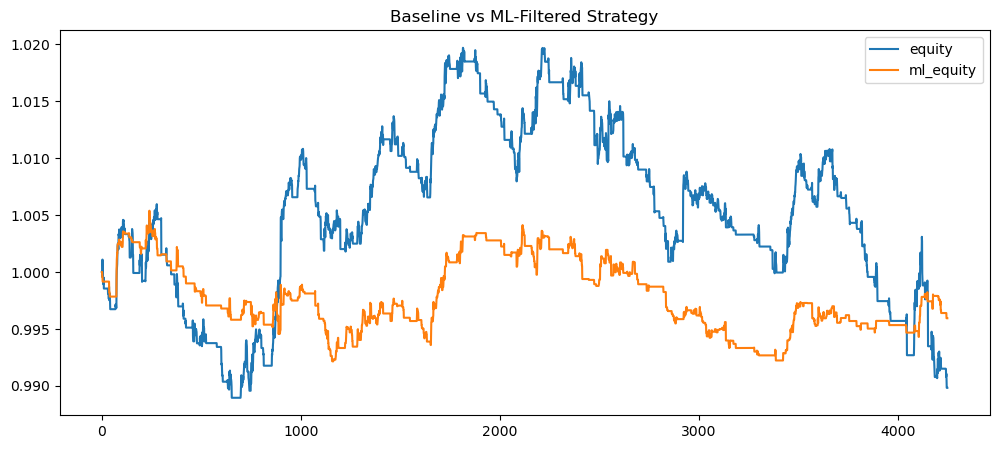

In [76]:
FEATURES = [
    'avg_iv',
    'iv_spread',
    'pcr_oi',
    'fut_basis',
    'spot_ret',
    'regime'        # 👈 this was your 6th feature
]

ml_df = df.loc[:, FEATURES + ['signal', 'spot_ret', 'equity', 'target']].copy()

# Remove duplicate columns if any
ml_df = ml_df.loc[:, ~ml_df.columns.duplicated()]

# Clean
ml_df.replace([np.inf, -np.inf], np.nan, inplace=True)
ml_df.dropna(inplace=True)
ml_df.reset_index(drop=True, inplace=True)

# Feature matrix
X = ml_df[FEATURES].astype(float).to_numpy()
y = ml_df['target'].to_numpy()

from xgboost import XGBClassifier

split = int(0.7 * len(ml_df))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

model = XGBClassifier(
    objective='binary:logistic',
    base_score=0.5,
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

model.fit(X_train, y_train)

# Predict
ml_pred = model.predict(X)

# ML signal
ml_signal = ml_df['signal'].values * (ml_pred == 1)

# ML returns
ml_ret = np.roll(ml_signal, 1) * ml_df['spot_ret'].values
ml_ret[0] = 0

# Equity
ml_equity = np.cumprod(1 + ml_ret)

# Final plot DF
result_df = pd.DataFrame({
    'equity': ml_df['equity'].values,
    'ml_equity': ml_equity
})

result_df.plot(figsize=(12,5))
plt.title("Baseline vs ML-Filtered Strategy")
plt.show()

In [77]:
# Create trade-level dataframe
trade_df = pd.DataFrame({
    'ml_ret': ml_ret,
    'equity': result_df['ml_equity'],
    'regime': ml_df['regime'].values,
    'spot_ret': ml_df['spot_ret'].values
})

# Remove zero-return rows (no trade)
trade_df = trade_df[trade_df['ml_ret'] != 0].copy()
trade_df.reset_index(drop=True, inplace=True)

trade_df.head()

,ml_ret,equity,regime,spot_ret
0,-0.000425,0.999575,1.0,-0.000425
1,-0.000417,0.999158,1.0,-0.000417
2,-0.000953,0.998206,1.0,-0.000953
3,-0.000366,0.997841,1.0,-0.000366
4,0.002479,1.000315,1.0,0.002479


In [79]:
from scipy.stats import zscore

trade_df['zscore'] = zscore(trade_df['ml_ret'])

# Outlier trades
outliers = trade_df[trade_df['zscore'].abs() > 3]

print("Total Trades:", len(trade_df))
print("Outlier Trades:", len(outliers))
print("Outlier Percentage:", round(len(outliers)/len(trade_df)*100, 2), "%")

Total Trades: 780
Outlier Trades: 8
Outlier Percentage: 1.03 %


In [80]:
summary = pd.DataFrame({
    'Metric': ['Avg Return', 'Median Return', 'Max Return'],
    'Normal Trades': [
        trade_df['ml_ret'].mean(),
        trade_df['ml_ret'].median(),
        trade_df['ml_ret'].max()
    ],
    'Outlier Trades': [
        outliers['ml_ret'].mean(),
        outliers['ml_ret'].median(),
        outliers['ml_ret'].max()
    ]
})

summary

,Metric,Normal Trades,Outlier Trades
0,Avg Return,-0.000005,0.000377
1,Median Return,-0.000004,-0.000061
2,Max Return,0.003954,0.003954


In [81]:
regime_dist = outliers['regime'].value_counts(normalize=True) * 100
regime_dist

regime
1.0    100.0
Name: proportion, dtype: float64

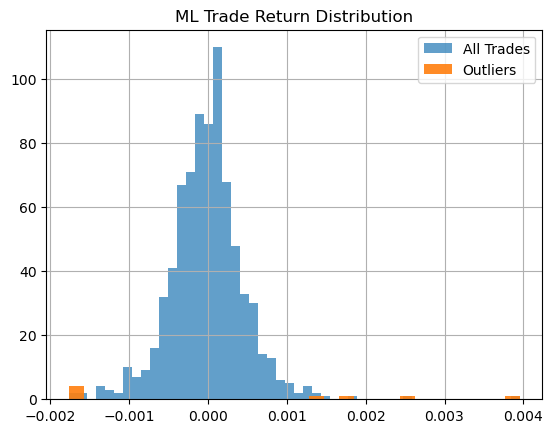

In [82]:
trade_df['ml_ret'].hist(bins=50, alpha=0.7, label='All Trades')
outliers['ml_ret'].hist(bins=30, alpha=0.9, label='Outliers')
plt.legend()
plt.title("ML Trade Return Distribution")
plt.show()

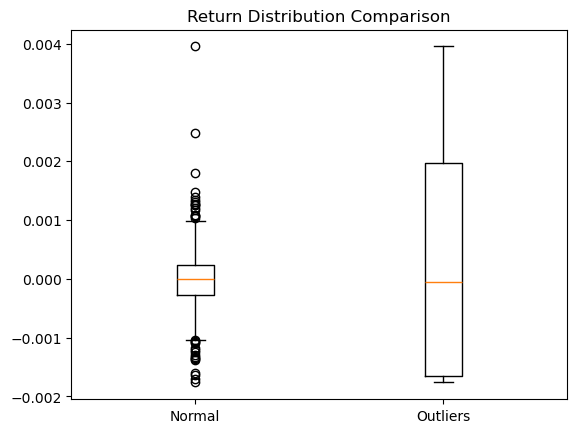

In [83]:
plt.boxplot([trade_df['ml_ret'], outliers['ml_ret']],
            labels=['Normal', 'Outliers'])
plt.title("Return Distribution Comparison")
plt.show()

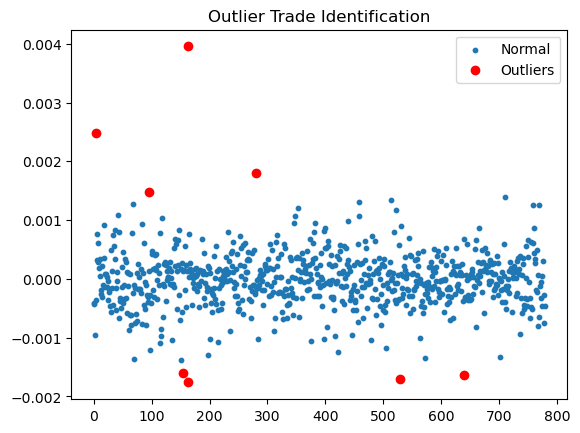

In [84]:
plt.scatter(range(len(trade_df)), trade_df['ml_ret'], s=10, label='Normal')
plt.scatter(outliers.index, outliers['ml_ret'], c='red', label='Outliers')
plt.legend()
plt.title("Outlier Trade Identification")
plt.show()

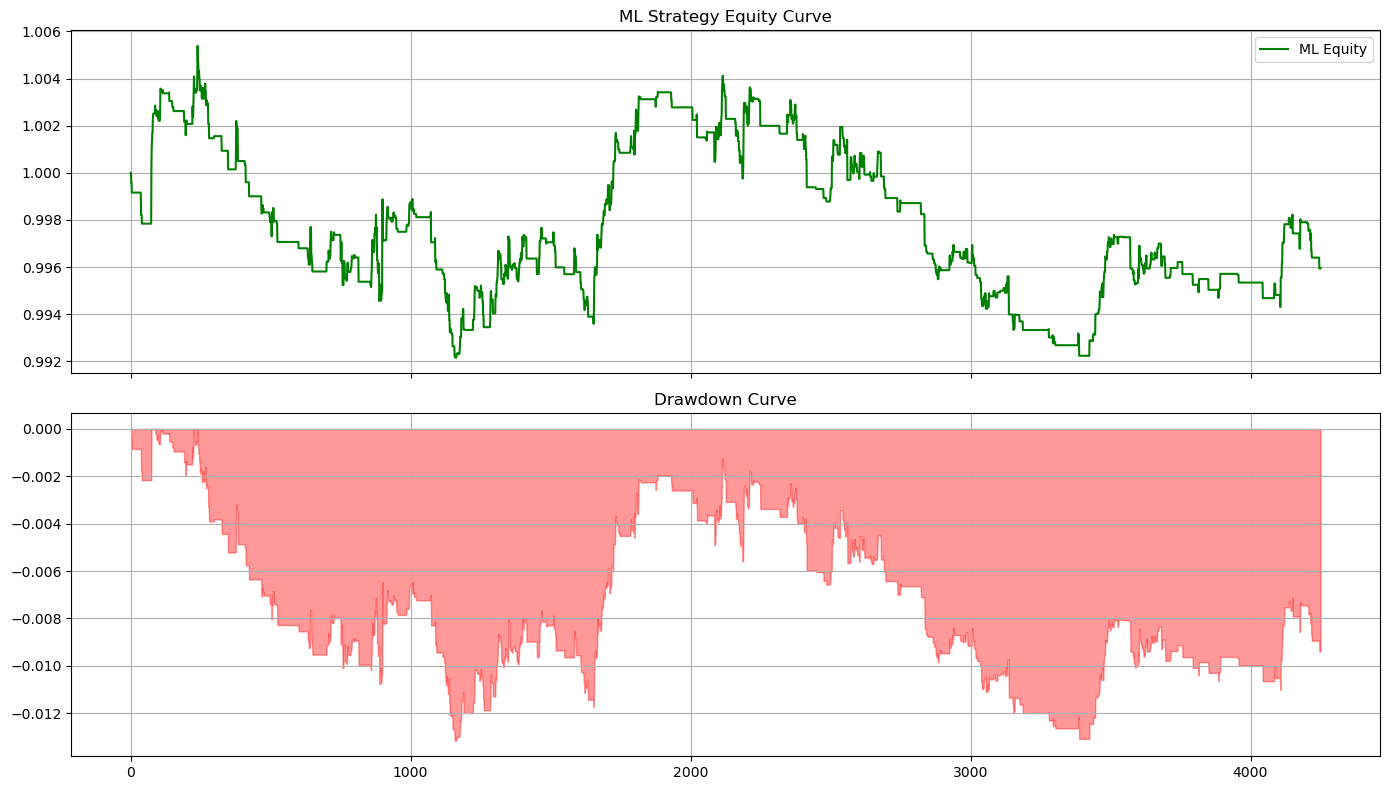

In [85]:
equity = result_df['ml_equity']
drawdown = equity / equity.cummax() - 1

fig, ax = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Equity
ax[0].plot(equity, label='ML Equity', color='green')
ax[0].set_title("ML Strategy Equity Curve")
ax[0].legend()
ax[0].grid(True)

# Drawdown
ax[1].fill_between(drawdown.index, drawdown, color='red', alpha=0.4)
ax[1].set_title("Drawdown Curve")
ax[1].grid(True)

plt.tight_layout()
plt.show()


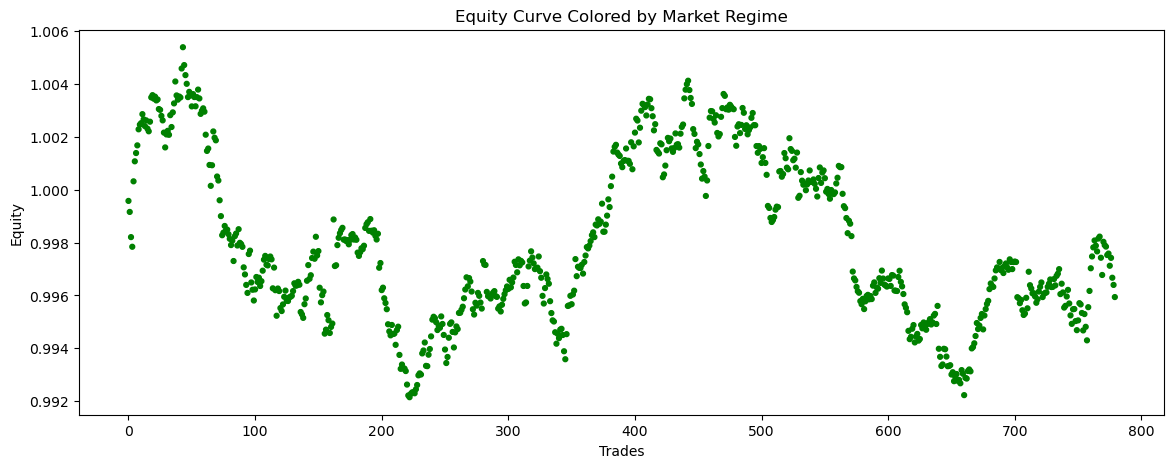

In [86]:
colors = trade_df['regime'].map({1:'green', 0:'gray', -1:'red'})

plt.figure(figsize=(14,5))
plt.scatter(trade_df.index, trade_df['equity'], c=colors, s=12)
plt.title("Equity Curve Colored by Market Regime")
plt.xlabel("Trades")
plt.ylabel("Equity")
plt.show()

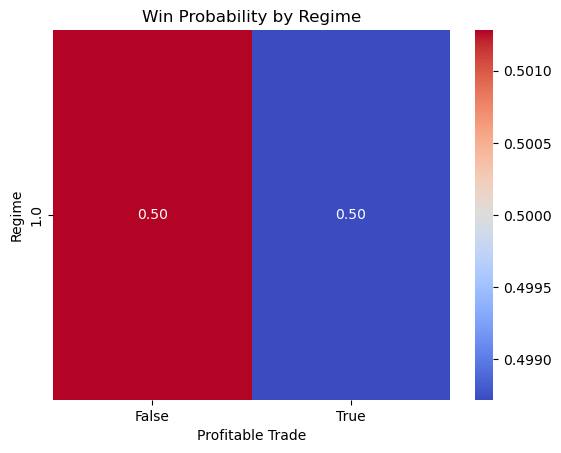

In [87]:
import seaborn as sns

heatmap_data = pd.crosstab(
    trade_df['regime'],
    trade_df['ml_ret'] > 0,
    normalize='index'
)

sns.heatmap(
    heatmap_data,
    annot=True,
    cmap='coolwarm',
    fmt='.2f'
)
plt.title("Win Probability by Regime")
plt.xlabel("Profitable Trade")
plt.ylabel("Regime")
plt.show()

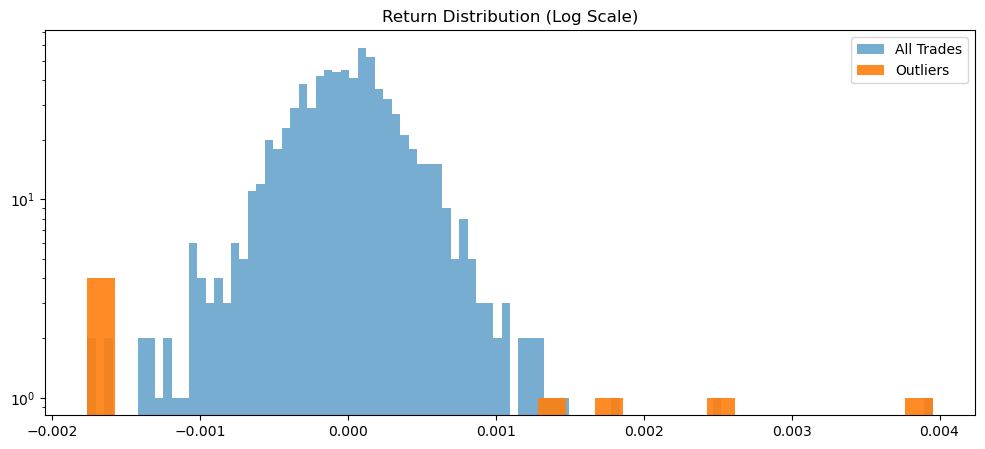

In [88]:
plt.figure(figsize=(12,5))
plt.hist(trade_df['ml_ret'], bins=100, alpha=0.6, label='All Trades')
plt.hist(outliers['ml_ret'], bins=30, alpha=0.9, label='Outliers')
plt.yscale('log')
plt.legend()
plt.title("Return Distribution (Log Scale)")
plt.show()

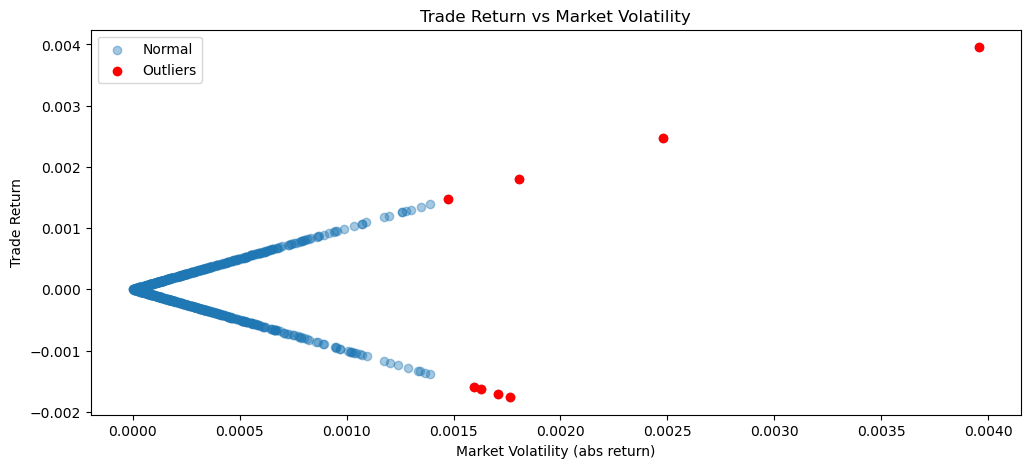

In [89]:
plt.figure(figsize=(12,5))
plt.scatter(
    trade_df['spot_ret'].abs(),
    trade_df['ml_ret'],
    alpha=0.4,
    label='Normal'
)
plt.scatter(
    outliers['spot_ret'].abs(),
    outliers['ml_ret'],
    color='red',
    label='Outliers'
)
plt.xlabel("Market Volatility (abs return)")
plt.ylabel("Trade Return")
plt.legend()
plt.title("Trade Return vs Market Volatility")
plt.show()

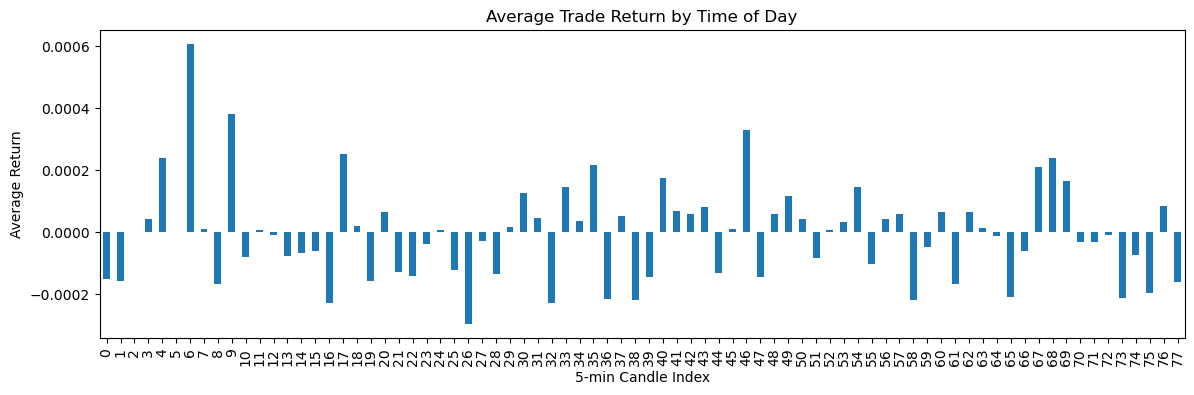

In [90]:
trade_df['hour'] = trade_df.index % 78  # Approx intraday bars

hour_perf = trade_df.groupby('hour')['ml_ret'].mean()

plt.figure(figsize=(14,4))
hour_perf.plot(kind='bar')
plt.title("Average Trade Return by Time of Day")
plt.xlabel("5-min Candle Index")
plt.ylabel("Average Return")
plt.show()

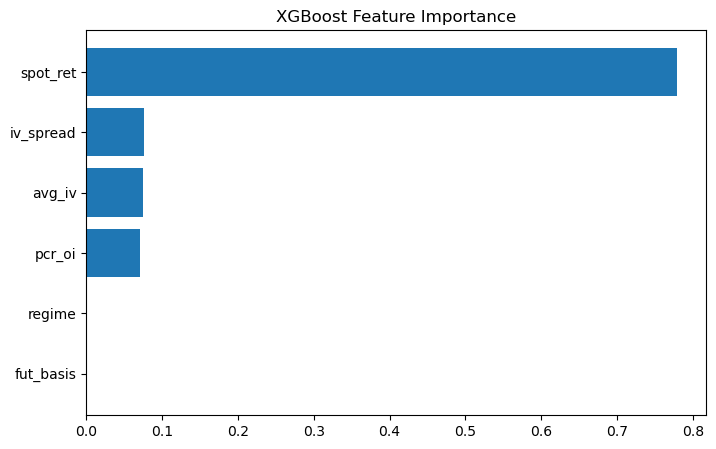

In [91]:
importance = model.feature_importances_

imp_df = pd.DataFrame({
    'Feature': FEATURES,
    'Importance': importance
}).sort_values(by='Importance', ascending=True)

plt.figure(figsize=(8,5))
plt.barh(imp_df['Feature'], imp_df['Importance'])
plt.title("XGBoost Feature Importance")
plt.show()

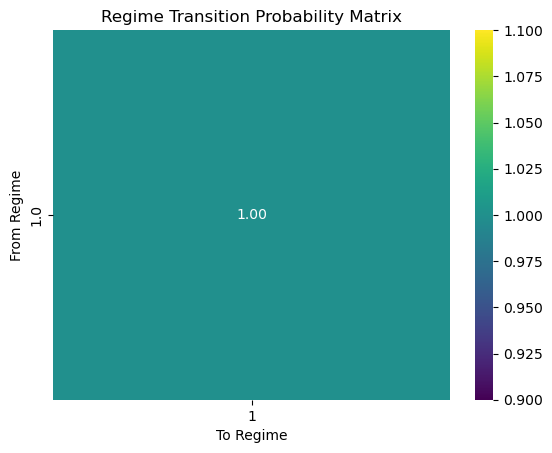

In [92]:
regime_series = df['regime'].dropna().astype(int)
transition = pd.crosstab(
    regime_series.shift(1),
    regime_series,
    normalize='index'
)

sns.heatmap(
    transition,
    annot=True,
    cmap='viridis',
    fmt='.2f'
)
plt.title("Regime Transition Probability Matrix")
plt.xlabel("To Regime")
plt.ylabel("From Regime")
plt.show()